In [74]:
import itertools as it
import networkx as nx
import matplotlib.pyplot as plt
import re
from pprint import pprint
from collections import Counter



In [75]:
# Read the SQL DDLs
DDL_file = "./test_parser.sql"
with open(DDL_file) as fp:
    ddl = fp.read()


In [76]:
def parse_ddl(ddl: str):
    """
    Parses SQL DDL statements and extracts table names, primary keys, and foreign keys.
    
    :param ddl: DDL string containing table definitions.
    :return: A list of dictionaries with keys: table_name, table_primary_key, table_foreign_keys.
    """
    tables_info = []
    
    # Split the DDL into individual CREATE TABLE statements
    table_statements = re.split(r"CREATE TABLE", ddl, flags=re.IGNORECASE)[1:]
    
    for statement in table_statements:
        # Extract table name
        table_name_match = re.search(r"(`\w+`)", statement)
        if not table_name_match:
            continue
        table_name = table_name_match.group(1)
        
        # Extract primary key
        primary_key_match = re.search(r"PRIMARY KEY \(([`\w`, ]+)\)", statement)
        primary_key = primary_key_match.group(1).split(",") if primary_key_match else []
        
        # Extract foreign keys
        fk_pattern = r"FOREIGN KEY \(([`\w`, ]+)\) REFERENCES ([`\w`]+) \(([`\w`, ]+)\)(?: ON DELETE (\w+))?"
        foreign_keys = []
        for fk_match in re.findall(fk_pattern, statement):
            from_columns = [col.strip(" ") for col in fk_match[0].split(",")]
            referenced_table = fk_match[1]
            referenced_columns = [col.strip(" ") for col in fk_match[2].split(",")]
            on_delete = fk_match[3] if fk_match[3] else "NO ACTION"
            
            foreign_keys.append({
                "columns": from_columns,
                "referenced_table": referenced_table,
                "referenced_columns": referenced_columns,
                "on_delete": on_delete
            })
        # Store table information
        tables_info.append({
            "table_name": table_name,
            "primary_keys": primary_key,
            "foreign_keys": foreign_keys
        })
    
    return tables_info

results = parse_ddl(ddl)
print(f"#Tables: {len(results)}")
# pprint(results)

#Tables: 13


NodeView(('`advisor`', '`classroom`', '`concept`', '`course`', '`department`', '`event_log`', '`instructor`', '`prereq`', '`section`', '`student`', '`takes`', '`teaches`', '`time_slot`'))
OutMultiEdgeView([('`advisor`', '`instructor`', '`ID`'), ('`advisor`', '`student`', '`ID`'), ('`course`', '`department`', '`dept_name`'), ('`instructor`', '`department`', '`dept_name`'), ('`prereq`', '`course`', '`course_id`'), ('`section`', '`course`', '`course_id`'), ('`section`', '`classroom`', '`building`'), ('`section`', '`classroom`', '`room_number`'), ('`student`', '`department`', '`dept_name`'), ('`takes`', '`section`', '`course_id`'), ('`takes`', '`section`', '`sec_id`'), ('`takes`', '`section`', '`semester`'), ('`takes`', '`section`', '`year`'), ('`takes`', '`student`', '`ID`'), ('`teaches`', '`section`', '`course_id`'), ('`teaches`', '`section`', '`sec_id`'), ('`teaches`', '`section`', '`semester`'), ('`teaches`', '`section`', '`year`'), ('`teaches`', '`instructor`', '`ID`')])


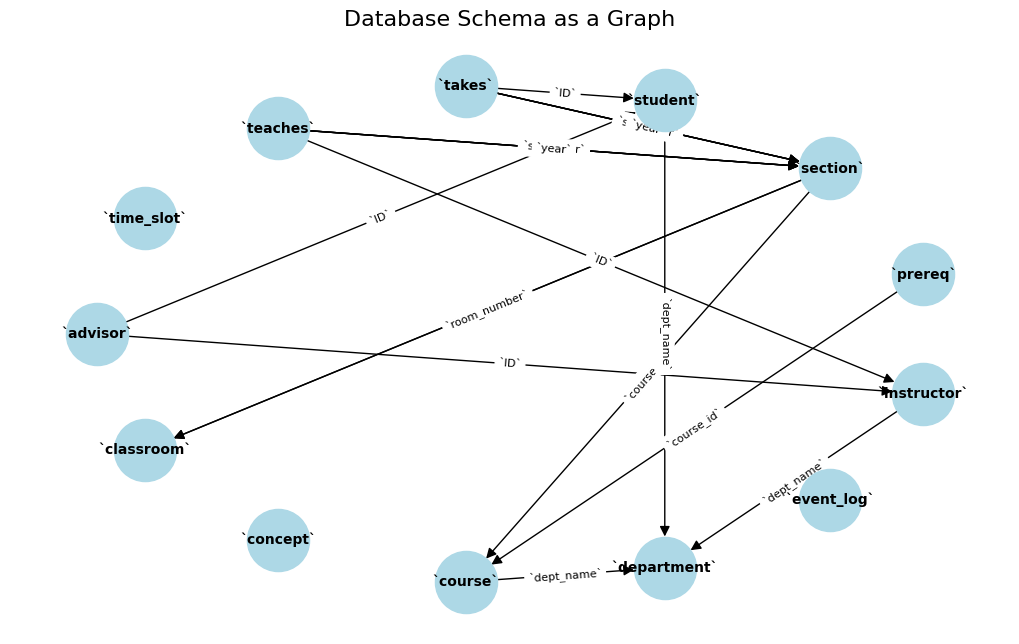

In [77]:
# Create a directed graph
graph = nx.MultiDiGraph()

# Add nodes (tables)
tables = [result["table_name"] for result in results]
graph.add_nodes_from(tables)

# Add Edges (the referenced table of the foreign key is the sink of the edge)
for result in results:
    if len(result['foreign_keys']) > 0:
        for foreign_key in result['foreign_keys']:
            for referenced_column in foreign_key["referenced_columns"]:
                edge_weight = 1
                # graph.add_edge(result['table_name'], foreign_key['referenced_table'],
                #                relation=referenced_column)
                graph.add_edge(result['table_name'], foreign_key['referenced_table'],
                               key=referenced_column, relation=referenced_column, weight = edge_weight)
                edge_weight += 1

pprint(graph.nodes)
pprint(graph.edges)
# Add edges (foreign key relationships)
# advisor.s_ID -> student.ID (ON DELETE CASCADE)
# graph.add_edge("`advisor`", "`student`", relation="advisor_ibfk_2: ON DELETE CASCADE")

# advisor.i_ID -> instructor.ID (ON DELETE SET NULL)
# graph.add_edge("`advisor`", "`instructor`", relation="advisor_ibfk_1: ON DELETE SET NULL")

# Visualize the graph
pos = nx.shell_layout(graph)  # Layout for better visualization
plt.figure(figsize=(10, 6))
nx.draw(graph, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold", arrowsize=15)
edge_labels = nx.get_edge_attributes(graph, "relation")
edge_weights = nx.get_edge_attributes(graph, "weight")

nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)
plt.title("Database Schema as a Graph", fontsize=16)
plt.show()

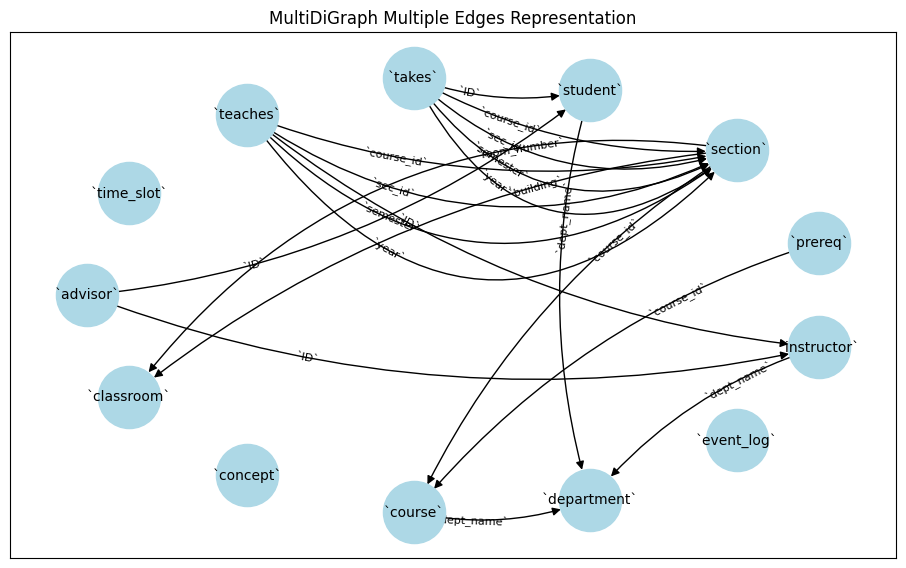

In [78]:
def draw_labeled_multigraph(graph):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.
    """
    fig, ax = plt.subplots(1, 1)

    fig.tight_layout()
    fig.set_size_inches(10, 6)
    # Works with arc3 and angle3 connectionstyles
    node_size = 2000
    attr_name = "relation"
    connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.15] * 20)]
    # connectionstyle = [f"angle3,angleA={r}" for r in it.accumulate([30] * 4)]

    pos = nx.shell_layout(graph)
    nx.draw_networkx_nodes(graph, pos, node_size=node_size,
                           node_color="lightblue", ax=ax)
    nx.draw_networkx_labels(graph, pos, font_size=10, ax=ax)
    nx.draw_networkx_edges(graph, pos,
                            arrows=True,
                            arrowsize=12,
                            node_size=node_size,
                            connectionstyle=connectionstyle,
                            edge_color="black",
                            ax=ax
                            )
    edge_labels = {
        tuple(edge): f"{attrs[attr_name]}"
        for *edge, attrs in graph.edges(keys=True, data=True)
    }
    nx.draw_networkx_edge_labels(
        graph,
        pos,
        edge_labels,
        connectionstyle=connectionstyle,
        label_pos=0.3,
        font_color="black",
        font_size=8,
        bbox={"alpha": 0},
        ax=ax,
    )
    ax.set_title("MultiDiGraph Multiple Edges Representation")

    plt.show()

draw_labeled_multigraph(graph)

[('`advisor`', '`instructor`', {'weight': 1}), ('`advisor`', '`student`', {'weight': 1}), ('`course`', '`department`', {'weight': 1}), ('`instructor`', '`department`', {'weight': 1}), ('`prereq`', '`course`', {'weight': 1}), ('`section`', '`course`', {'weight': 1}), ('`section`', '`classroom`', {'weight': 2}), ('`student`', '`department`', {'weight': 1}), ('`takes`', '`section`', {'weight': 4}), ('`takes`', '`student`', {'weight': 1}), ('`teaches`', '`section`', {'weight': 4}), ('`teaches`', '`instructor`', {'weight': 1})]


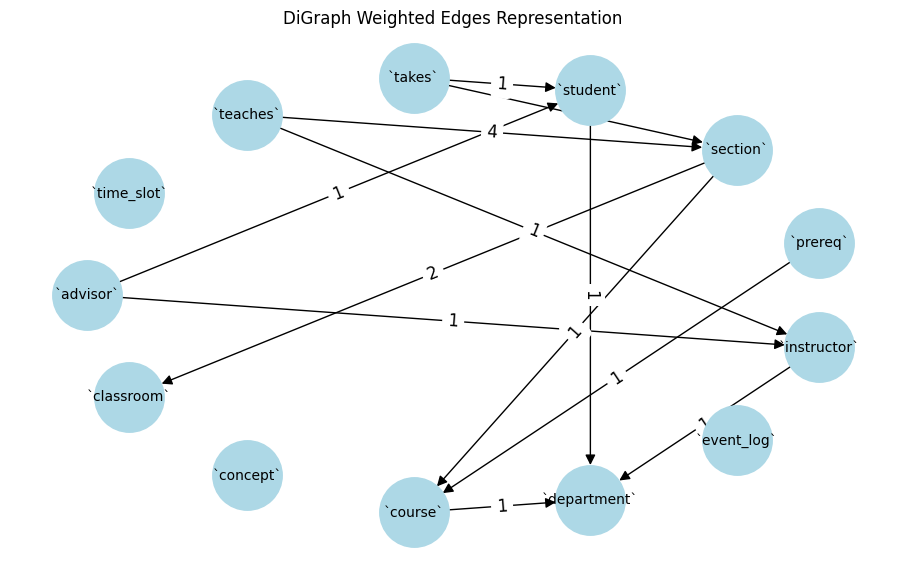

In [81]:
def draw_weighted_graph(graph: nx.MultiDiGraph):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.
    """
    fig, ax = plt.subplots(1, 1)

    fig.tight_layout()
    fig.set_size_inches(10, 6)
    # Works with arc3 and angle3 connectionstyles
    node_size = 2500

    c = Counter(graph.edges())
    simple_digraph = nx.DiGraph()
    simple_digraph.add_nodes_from(graph)

    for u, v, d in graph.edges(data=True):
        # avoid repeating edges and self-loops
        if not simple_digraph.has_edge(u, v) and u != v:
            simple_digraph.add_edge(u, v, weight=c[u, v])

    print(list(simple_digraph.edges(data=True)))

    pos = nx.shell_layout(simple_digraph)
    nx.draw(simple_digraph, pos, with_labels=True, node_size=node_size,
            node_color="lightblue", font_size=10, 
            arrowsize=15, 
            ax=ax)
    edge_labels = nx.get_edge_attributes(simple_digraph, "weight")

    nx.draw_networkx_edge_labels(simple_digraph, pos, edge_labels=edge_labels, font_size=12, ax=ax)
    ax.set_title("DiGraph Weighted Edges Representation")
    plt.show()


draw_weighted_graph(graph)